In [1]:
# Dataset Showcase

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('MobiFall_Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


MobiFall_Dataset\Readme.txt
MobiFall_Dataset\sub1\FALLS\BSC\BSC_acc_1_1.txt
MobiFall_Dataset\sub1\FALLS\BSC\BSC_acc_1_2.txt
MobiFall_Dataset\sub1\FALLS\BSC\BSC_acc_1_3.txt
MobiFall_Dataset\sub1\FALLS\BSC\BSC_gyro_1_1.txt
MobiFall_Dataset\sub1\FALLS\BSC\BSC_gyro_1_2.txt
MobiFall_Dataset\sub1\FALLS\BSC\BSC_gyro_1_3.txt
MobiFall_Dataset\sub1\FALLS\BSC\BSC_ori_1_1.txt
MobiFall_Dataset\sub1\FALLS\BSC\BSC_ori_1_2.txt
MobiFall_Dataset\sub1\FALLS\BSC\BSC_ori_1_3.txt
MobiFall_Dataset\sub1\FALLS\FKL\FKL_acc_1_1.txt
MobiFall_Dataset\sub1\FALLS\FKL\FKL_acc_1_2.txt
MobiFall_Dataset\sub1\FALLS\FKL\FKL_acc_1_3.txt
MobiFall_Dataset\sub1\FALLS\FKL\FKL_gyro_1_1.txt
MobiFall_Dataset\sub1\FALLS\FKL\FKL_gyro_1_2.txt
MobiFall_Dataset\sub1\FALLS\FKL\FKL_gyro_1_3.txt
MobiFall_Dataset\sub1\FALLS\FKL\FKL_ori_1_1.txt
MobiFall_Dataset\sub1\FALLS\FKL\FKL_ori_1_2.txt
MobiFall_Dataset\sub1\FALLS\FKL\FKL_ori_1_3.txt
MobiFall_Dataset\sub1\FALLS\FOL\FOL_acc_1_1.txt
MobiFall_Dataset\sub1\FALLS\FOL\FOL_acc_1_2.txt
MobiFa

In [2]:
# Cell 1: Imports and Configuration

import os
import glob
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import io
import joblib

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
DATASET_PATH = 'MobiFall_Dataset'
TARGET_SAMPLING_RATE_HZ = 50.0  # Target sampling rate in Hz
TARGET_SAMPLING_PERIOD = f"{int(1000 / TARGET_SAMPLING_RATE_HZ)}ms"
SEQUENCE_LENGTH = int(TARGET_SAMPLING_RATE_HZ * 4) # 200 samples for 4 seconds at 50Hz
STEP = int(TARGET_SAMPLING_RATE_HZ * 1)          # 50 samples for 1 second step at 50Hz

SENSOR_CODES = ["acc", "gyro", "ori"]
EXPECTED_COLUMNS = {
    "acc": ["acc_x", "acc_y", "acc_z"],
    "gyro": ["gyro_x", "gyro_y", "gyro_z"],
    "ori": ["ori_azimuth", "ori_pitch", "ori_roll"]
}
ALL_FEATURE_COLUMNS = [
    "acc_x", "acc_y", "acc_z", "acc_smv",      # acc_smv added
    "gyro_x", "gyro_y", "gyro_z", "gyro_smv", # gyro_smv added
    "ori_azimuth", "ori_pitch", "ori_roll"
]

In [3]:
# Cell 2: Data Loading and Preprocessing Functions

def load_and_resample_sensor_file(filepath, sensor_code):
    """Loads a single sensor file, converts timestamps, and resamples."""
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()

        data_start_line_index = -1
        for i, line in enumerate(lines):
            if line.strip().upper() == "@DATA":
                data_start_line_index = i + 1
                break
        if data_start_line_index == -1 or data_start_line_index >= len(lines):
            return None # No data marker or no data after marker

        data_string = "".join(lines[data_start_line_index:])
        if not data_string.strip():
            return None # No data content

        df = pd.read_csv(io.StringIO(data_string), header=None, usecols=[0, 1, 2, 3])
        if df.empty:
            return None

        df.columns = ['timestamp_ns'] + EXPECTED_COLUMNS[sensor_code]
        df['timestamp'] = pd.to_datetime(df['timestamp_ns'], unit='ns')
        df = df.set_index('timestamp').drop(columns=['timestamp_ns'])
        df = df.sort_index()

        df_resampled = df.resample(TARGET_SAMPLING_PERIOD).mean().interpolate(method='linear', limit_direction='both')

        if sensor_code == 'acc':
            if all(col in df_resampled.columns for col in ['acc_x', 'acc_y', 'acc_z']):
                df_resampled['acc_smv'] = np.sqrt(df_resampled['acc_x']**2 + df_resampled['acc_y']**2 + df_resampled['acc_z']**2)
        elif sensor_code == 'gyro':
            if all(col in df_resampled.columns for col in ['gyro_x', 'gyro_y', 'gyro_z']):
                df_resampled['gyro_smv'] = np.sqrt(df_resampled['gyro_x']**2 + df_resampled['gyro_y']**2 + df_resampled['gyro_z']**2)
        
        return df_resampled

    except (pd.errors.EmptyDataError, ValueError):
        return None
    except Exception as e:
        print(f"Error processing/resampling file {filepath}: {e}. Skipping.")
        return None

def load_data_from_structured_folders(dataset_root_path):
    """Walks through the dataset folder, processes, aligns, and combines sensor data for each trial."""
    print(f"Scanning for data in: {dataset_root_path}")
    if not os.path.isdir(dataset_root_path):
        print(f"ERROR: Dataset root path '{dataset_root_path}' not found.")
        return [], []

    trial_sensor_files_map = defaultdict(lambda: defaultdict(str))
    trial_metadata_map = {}
    
    # First pass: Collect all file paths for each trial
    for dirpath, _, filenames in os.walk(dataset_root_path):
        relative_path = os.path.relpath(dirpath, dataset_root_path)
        path_parts = relative_path.split(os.sep)
        if len(path_parts) != 3: continue

        for filename in filenames:
            if not filename.endswith(".txt"): continue
            filepath = os.path.join(dirpath, filename)
            fname_parts = filename.replace('.txt', '').split('_')
            if len(fname_parts) != 4: continue
            _, sensor_code, _, trial_no_str = fname_parts
            sensor_code = sensor_code.lower()
            if sensor_code not in SENSOR_CODES: continue
            
            try:
                subject_id = int(re.fullmatch(r'sub(\d+)', path_parts[0], re.IGNORECASE).group(1))
                category = path_parts[1].upper()
                activity_code = path_parts[2].upper()
                trial_no = int(trial_no_str)
                
                trial_key = (subject_id, activity_code, trial_no)
                trial_sensor_files_map[trial_key][sensor_code] = filepath
                if trial_key not in trial_metadata_map:
                    trial_metadata_map[trial_key] = {"category": category, "activity_code": activity_code}
            except (AttributeError, ValueError):
                continue
    
    # Second pass: Process each trial
    processed_trials_data, labels = [], []
    print(f"\nProcessing and combining {len(trial_sensor_files_map)} unique trials...")
    
    for trial_key, sensor_files in trial_sensor_files_map.items():
        if not all(s_code in sensor_files for s_code in SENSOR_CODES): continue

        resampled_dfs = {s_code: load_and_resample_sensor_file(sensor_files[s_code], s_code) for s_code in SENSOR_CODES}
        if any(df is None or df.empty for df in resampled_dfs.values()): continue

        try:
            common_start = max(df.index.min() for df in resampled_dfs.values())
            common_end = min(df.index.max() for df in resampled_dfs.values())
            if common_start >= common_end: continue

            aligned_dfs = [resampled_dfs[s_code][common_start:common_end].reset_index(drop=True) for s_code in SENSOR_CODES]
            if not all(len(df) > 0 and len(df) == len(aligned_dfs[0]) for df in aligned_dfs): continue
            
            combined_df = pd.concat(aligned_dfs, axis=1)
            combined_df.columns = ALL_FEATURE_COLUMNS

            if len(combined_df) < SEQUENCE_LENGTH: continue
                
            processed_trials_data.append(combined_df.values)
            labels.append(1 if trial_metadata_map[trial_key]["category"] == "FALLS" else 0)
        except Exception:
            continue

    print(f"Successfully processed and combined sensor data for {len(processed_trials_data)} trials.")
    return processed_trials_data, labels

def create_sequences(data_list, label_list, seq_length, step):
    """Creates sequences from trial data using a sliding window."""
    X, y = [], []
    for i, trial_data in enumerate(data_list):
        trial_label = label_list[i]
        for j in range(0, len(trial_data) - seq_length + 1, step):
            sequence = trial_data[j:(j + seq_length)]
            X.append(sequence)
            y.append(trial_label)
    if not X: return np.array([]), np.array([])
    return np.array(X), np.array(y)

In [4]:
# Cell 3: Execute Data Loading and Sequence Creation

# Load trial data from folders
trial_arrays, trial_labels = load_data_from_structured_folders(DATASET_PATH)

if not trial_arrays:
    print("No data loaded. Check dataset path and file integrity.")
else:
    # Create sequences using the sliding window method
    X_sequences, y_sequences = create_sequences(trial_arrays, trial_labels, SEQUENCE_LENGTH, STEP)
    
    if X_sequences.size == 0:
        print("\nNo sequences created. Check trial lengths and SEQUENCE_LENGTH/STEP.")
    else:
        print(f"\nSuccessfully created {X_sequences.shape[0]} sequences.")
        print(f"Shape of X_sequences: {X_sequences.shape}")
        print(f"Shape of y_sequences: {y_sequences.shape}")
        print("\nLabel distribution (per sequence):")
        print(pd.Series(y_sequences).value_counts(normalize=True))

Scanning for data in: MobiFall_Dataset

Processing and combining 627 unique trials...
Successfully processed and combined sensor data for 627 trials.

Successfully created 9491 sequences.
Shape of X_sequences: (9491, 200, 11)
Shape of y_sequences: (9491,)

Label distribution (per sequence):
0    0.816036
1    0.183964
Name: proportion, dtype: float64


In [ ]:
# Cell 4: Dataset Splitting and Scaling

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.25, random_state=42, stratify=y_sequences
)

print(f"Train set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Scale the features
scaler = StandardScaler()

# Reshape for scaling: (num_samples * sequence_length, num_features)
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
scaler.fit(X_train_reshaped)

# Transform both train and test sets
X_train = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
X_test = scaler.transform(X_test_reshaped).reshape(X_test.shape)

print("\nData has been successfully split and scaled.")

# Save the scaler for later use (e.g., in deployment)
scaler_save_path = "scaler_50hz.gz"
joblib.dump(scaler, scaler_save_path)
print(f"Scaler saved to {scaler_save_path}")

Train set shape: (7118, 200, 11), (7118,)
Test set shape: (2373, 200, 11), (2373,)

Data has been successfully split and scaled.
Scaler saved to scaler_50hz.gz


In [6]:
# Cell 5: Build and Compile the Model

model = Sequential([
    Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(SEQUENCE_LENGTH, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Bidirectional(LSTM(64, return_sequences=True)), 
    Dropout(0.4),
    
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.4),
    
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Binary classification
])

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

c:\Users\ghost\anaconda3\envs\falldetect1\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 191, 64)        │         7,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 95, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 95, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,481 (455.00 KB)

 Trainable params: 116,481 (455.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cell 6: Train the Model and Save

# Define callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]

# Calculate class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Calculated Class Weights: {class_weight_dict}")

print("\nStarting model training...")
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=64, 
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)
print("\nTraining finished.")


model_save_path = "fall_detection_model_50hz.keras"
model.save(model_save_path)
print(f"\nModel successfully saved to {model_save_path}")

Calculated Class Weights: {0: np.float64(0.6126699948355999), 1: np.float64(2.7188693659281893)}

Starting model training...
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9601 - loss: 0.1878 - val_accuracy: 0.9782 - val_loss: 0.0783 - learning_rate: 0.0010
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9782 - loss: 0.0479 - val_accuracy: 0.9775 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9840 - loss: 0.0410 - val_accuracy: 0.9888 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9882 - loss: 0.0374 - val_accuracy: 0.9867 - val_loss: 0.0316 - learning_rate: 0.0010
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9877 - loss: 0.0293 - val_accuracy: 0.9944 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9917 - loss: 0.0243 - val_accuracy: 0.9944 - val_loss:

Evaluating model on the test set...
Test Loss: 0.0177
Test Accuracy: 0.9962
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


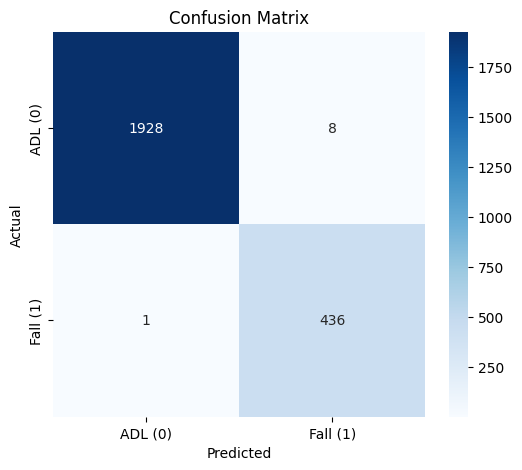


Classification Report:

              precision    recall  f1-score   support

     ADL (0)       1.00      1.00      1.00      1936
    Fall (1)       0.98      1.00      0.99       437

    accuracy                           1.00      2373
   macro avg       0.99      1.00      0.99      2373
weighted avg       1.00      1.00      1.00      2373



In [8]:
# Cell 7: Evaluate and Visualize Results

# Evaluate the model on the test set
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten() # Using 0.5 as threshold

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ADL (0)', 'Fall (1)'], 
            yticklabels=['ADL (0)', 'Fall (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['ADL (0)', 'Fall (1)']))

In [15]:
from tensorflow.keras.models import load_model

model = load_model('fall_detection_model_50hz.keras')


In [16]:
import numpy as np

# Example input: 1 sample, 100 timesteps, 6 features (e.g., accelerometer + gyroscope)
sample_input = np.random.rand(1, 100, 6)  # Replace with real data


In [17]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 191, 64)        │         7,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 95, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 95, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,445 (1.33 MB)

 Trainable params: 116,481 (455.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,964 (910.02 KB)